# Handling The MNIST Dataset with TFLearn

Here I'll be messing around with the MNIST Dataset using TFLearn.

In [1]:
import datetime as dt
import random, os
import tflearn
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
sns.set()

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train_data = mnist.train.images
targets = mnist.train.labels
targets = targets.astype(np.float32)

In [4]:
def bad_MNIST_net():
    # Build neural network
    net = tflearn.input_data(shape=[None, 784])
    net = tflearn.fully_connected(net, 16)
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net)
    return net

In [5]:
def better_MNIST_net():
    # Build neural network
    net = tflearn.input_data(shape=[None, 784])
    net = tflearn.fully_connected(net, 128, activation='relu')
    net = tflearn.fully_connected(net, 64,  activation='relu')
    net = tflearn.fully_connected(net, 32,  activation='tanh')
    net = tflearn.fully_connected(net, 10,  activation='softmax')
    net = tflearn.regression(net)
    return net

In [6]:
tf.reset_default_graph()
net = bad_MNIST_net()
model = tflearn.DNN(net, 
                    tensorboard_verbose=1,
                    tensorboard_dir='tflearn_logs')

In [7]:
# Start training (apply gradient descent algorithm)
model.fit(train_data, 
          targets, 
          n_epoch=10, 
          batch_size=1000, 
          show_metric=True)

Training Step: 549  | total loss: 0.13837 | time: 3.903s
| Adam | epoch: 010 | loss: 0.13837 - acc: 0.9654 -- iter: 54000/55000
Training Step: 550  | total loss: 0.13623 | time: 3.977s
| Adam | epoch: 010 | loss: 0.13623 - acc: 0.9660 -- iter: 55000/55000
--


In [8]:
test_images = mnist.test.images
prediction = model.predict(test_images)
prediction = np.array(prediction)

In [9]:
test_target = mnist.test.labels

## Analysing the Model

Now we can take some time to analyse the accuracy of the model, in particular where the errors in the model are and why.

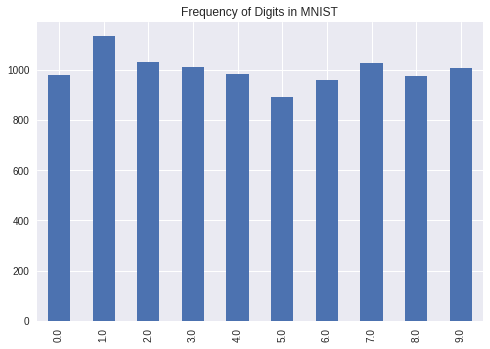

In [10]:
targets = np.dot(test_target, np.arange(10))
targ_freqs = pd.Series(targets)\
               .value_counts()\
               .sort_index()
targ_freqs.plot(kind='bar',
                title='Frequency of Digits in MNIST')

## Confusion Matrix

Creating a confusion matrix sounds like a good idea.

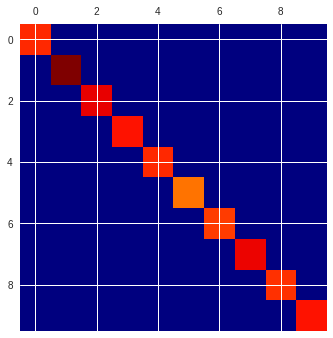

In [11]:
plt.matshow(np.dot(test_target.T, test_target))
plt.set_cmap('jet')

In [12]:
confusion_matrix = np.dot(test_target.T, prediction)

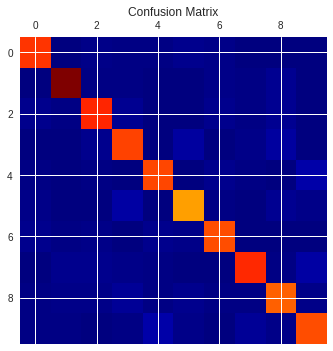

In [13]:
plt.matshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.set_cmap('jet')

You can see here that the model is actually pretty good, and that it found the `1`s most easy to predict, and the `5`s and `8`s most difficult to predict. In fact you can sort of see that the model sometimes got the `5`s and `8`s mixed up. 

Next, we can rescale the colour map with a logarithm to increase the contrast in the image. This will allow us to better visualise what is going on in the blueish area of the confusion matrix.

/home/user/Programs/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


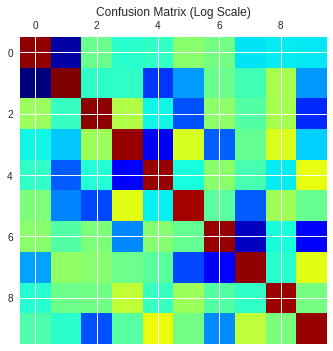

In [21]:
plt.matshow(np.log(confusion_matrix))
plt.title("Confusion Matrix (Log Scale)")
plt.legend()
plt.set_cmap('jet')

Now we can see where the problems are much more clearly. The 'hot colours' indicate predictions that were made with high certainty. In the case of the main diagonal, this means that the model made confident predictions that were also correct. Off the main diagonal however, hot spots indicate false positives that were predicted with high confidence.

With this in mind, we can notice a few features of the model. Firstly, in the top left you can see that `0`s and `1`s were rarely mistaken for one another with high confidence. This means that the model has a pretty good idea of what constitutes `0`-ness and `1`-ness.

One notable set of errors (although there are others) is with the `3`s. They are most commonly mistaken for 2s, 5s and 8s. Also interestingly, the model seems to pretty confidently distinguish `6`s and `9`s, which one might have expected them to get mixed up.

## Plotting the Accuracy of the Model

We can take a quick moment to plot the proportion of incorrect predictions from the model.

In [15]:
preds = np.argmax(prediction, axis=1)
targs = np.argmax(test_target, axis=1)
hits = preds == targs

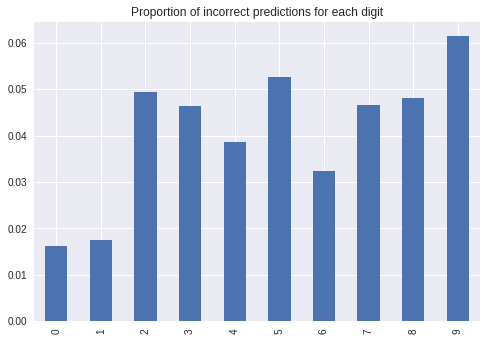

In [16]:
miss_freqs = pd.Series(targs[hits == False])\
               .value_counts()\
               .sort_index()
miss_probs = miss_freqs / targ_freqs
miss_probs.plot(kind = 'bar',
                title = 'Proportion of incorrect predictions for each digit')

In [17]:
print("Accuracy: %.2f%%" % (100 * (1 - miss_probs.mean())))

Accuracy: 95.90%


## Sampling from the Confusion Matrix

Here I would like to be able to select out examples of digits that look like other digits. For example, to find some `9`s that look like `7`s etc.

In [18]:
import random

def sample_predictions(pred, targ):
    '''Returns a digit that the model misclassified as pred
       when the true value was targ'''
    mask = np.logical_and(preds == pred, targs == targ)
    sample = test_images[mask, :]
    x, y = sample.shape
    i = random.randint(0, x) - 1
    return sample[i,:].reshape(28,28)

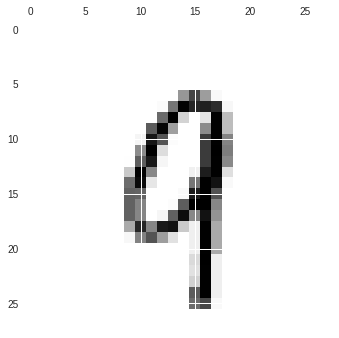

In [19]:
plt.matshow(sample_predictions(4,9))
plt.set_cmap('Greys')